This file is about evaluating diffrent models to find the best segmentation for our model

In [9]:
from transformers import pipeline
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import evaluation

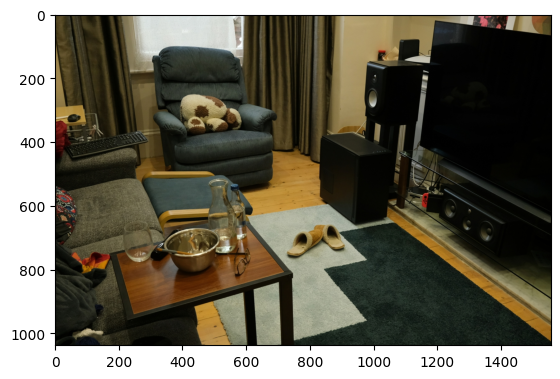

In [10]:
#Load Image
#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/segmentation_input.jpg"
#url = "https://images.squarespace-cdn.com/content/v1/5d00ff1460665300016b8dc9/1560889669316-Y1NYTQY2Q3WL0GLKPNTY/IMG_20180622_134600.jpg"
url = "https://hips.hearstapps.com/hmg-prod/images/small-living-room-ideas-lisa-dawson-66ba2b7398f74.jpeg?crop=1xw:0.9900990099009901xh;center,top&resize=980:*"
#image = Image.open(requests.get(url, stream=True).raw)
#img_path = "..\\Image_Segmentation\\labels\\0001_3\\img.png"
img_path = "..\\gt\\DSCF4667.png"
image = Image.open(img_path)

plt.imshow(image)
plt.show()

Get prediction masks

In [11]:
#Instance Segmentation
#instance_segmentation = pipeline("image-segmentation", "facebook/mask2former-swin-large-cityscapes-instance", device='cuda')
instance_segmentation = pipeline("image-segmentation", "nvidia/segformer-b1-finetuned-cityscapes-1024-1024", device='cuda')
results = instance_segmentation(image)
print(results)
nb_mask = len(results)

[{'score': None, 'label': 'road', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207C63E50D0>}, {'score': None, 'label': 'sidewalk', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207E1524F10>}, {'score': None, 'label': 'building', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207C5827E90>}, {'score': None, 'label': 'fence', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207C6410810>}, {'score': None, 'label': 'pole', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207E14C2DD0>}, {'score': None, 'label': 'traffic sign', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207E14568D0>}, {'score': None, 'label': 'person', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207E1517F50>}, {'score': None, 'label': 'car', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207C5A3D090>}, {'score': None, 'label': 'truck', 'mask': <PIL.Image.Image image mode=L size=1557x1038 at 0x207C5B614D0>}, {'score': None, 'label': '

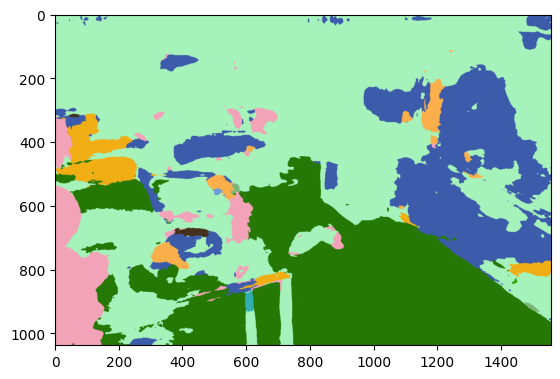

In [12]:
masks = [np.array(results[i]["mask"]) for i in range(nb_mask)]
segmentation_map = evaluation.generate_segmentation_map(masks)

plt.imshow(segmentation_map)

Get ground truth masks

In [15]:
label_png = "..\\Image_Segmentation\\labels\\DSCF4667\\label.png" #this is generated by lableme

lbl = np.asarray(Image.open(label_png))
print(np.array(image).shape)
print(lbl.shape)
nb_labels = np.max(np.unique(lbl))
gt_masks = [np.where(lbl == i, 1, 0) for i in range(1,nb_labels+1)]

segmentation_map = evaluation.generate_segmentation_map(gt_masks)


(1038, 1557, 3)
(1038, 1557)


the max ious of mask 0 is: 0 with iou = 0.6102676965087565
the max ious of mask 1 is: 11 with iou = 0.0004510221420405081
the max ious of mask 2 is: 3 with iou = 0.11836367836671047
the max ious of mask 3 is: 10 with iou = 0.11035199762364474
the max ious of mask 4 is: 0 with iou = 0.005603068072866731
the max ious of mask 5 is: 12 with iou = 0.0006148989087838768
the max ious of mask 6 is: 11 with iou = 0.06260427659311052
the max ious of mask 7 is: 2 with iou = 0.0730775857118245
the max ious of mask 8 is: 1 with iou = 0.19899836842825255
the max ious of mask 9 is: 0 with iou = 0
the max ious of mask 10 is: 17 with iou = 0.03054269547325103
the max ious of mask 11 is: 2 with iou = 0.10947616244849911


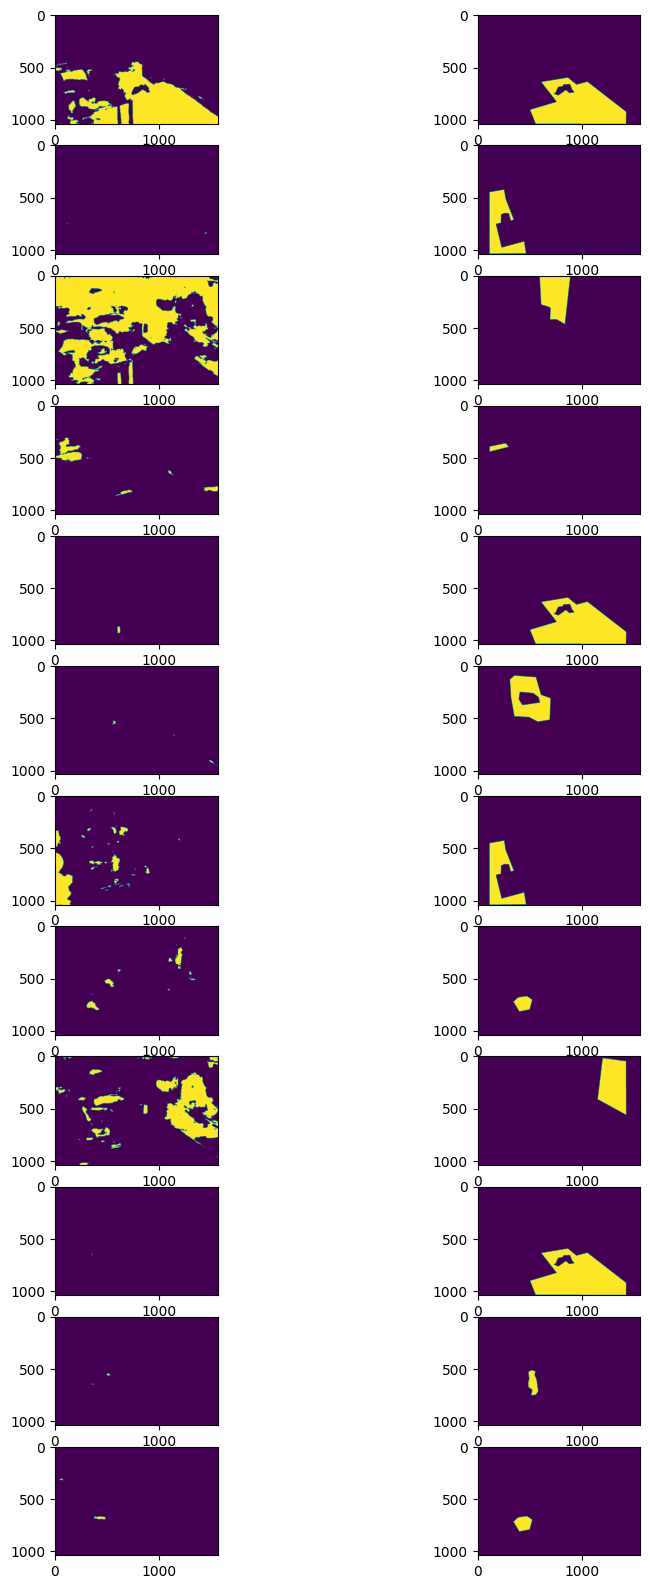

In [17]:
#evaluate the model
ious = evaluation.get_ious_from_masks(masks, gt_masks)

for i in range(len(ious)):
    print(f"the max ious of mask {i} is: {ious[i][1]} with iou = {ious[i][0]}")

best_match_num = len(masks)
fig, ax = plt.subplots(best_match_num, 2, figsize=(10, 20))  # 1 row, 2 columns

for i in range(best_match_num):
    ax[i,0].imshow(masks[i])
    ax[i,1].imshow(gt_masks[ious[i][1]])

Nvidia segmentation model doesn't seems to work fine

The problem maybe due to the dataset, let's try a model that is trained by coco dataset 

In [18]:
import requests
from PIL import Image
import torch
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on COCO instance segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-coco-instance")

#image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_instance_map = result["segmentation"]

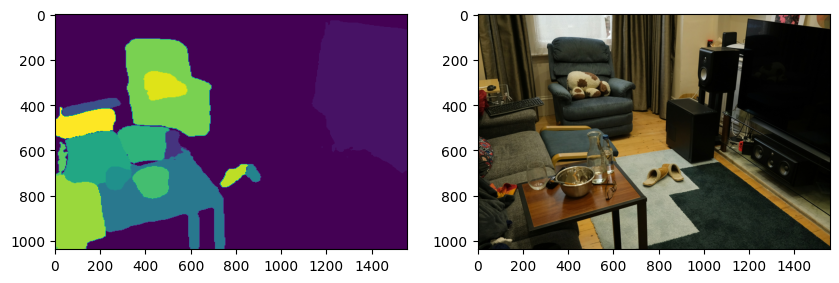

In [19]:
# Create a figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

predicted_array = np.array(predicted_instance_map)
ax[0].imshow(predicted_array)
ax[1].imshow(image)

19


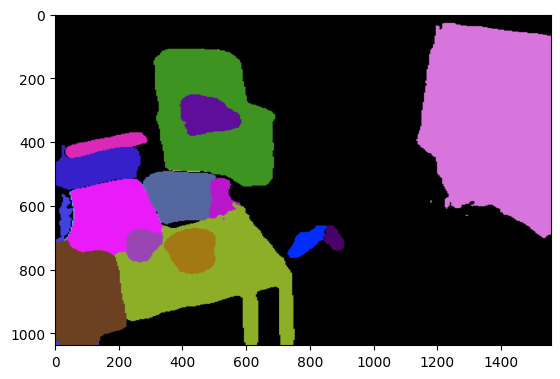

In [20]:
#generate masks
nb_mask = int(np.max(np.unique(predicted_array)))
masks = []
print(nb_mask)
for i in range(nb_mask+1):
    mask = np.where(predicted_array == i, 255, 0)
    masks.append(mask)

segmentation_map = evaluation.generate_segmentation_map(masks)
plt.imshow(segmentation_map)


the max ious of mask 0 is: 1 with iou = 0.5041818687081477
the max ious of mask 1 is: 12 with iou = 0.0006952620210803445
the max ious of mask 2 is: 17 with iou = 0.4208024691358025
the max ious of mask 3 is: 0 with iou = 0
the max ious of mask 4 is: 10 with iou = 0.6077910174152154
the max ious of mask 5 is: 0 with iou = 0
the max ious of mask 6 is: 0 with iou = 0
the max ious of mask 7 is: 17 with iou = 0.06931422892164983
the max ious of mask 8 is: 13 with iou = 0.3149920996375128
the max ious of mask 9 is: 9 with iou = 0.6511390683441006
the max ious of mask 10 is: 11 with iou = 7.309712519449057e-05
the max ious of mask 11 is: 11 with iou = 0.3117700970028039
the max ious of mask 12 is: 17 with iou = 0.005728461885430762
the max ious of mask 13 is: 2 with iou = 0.8998851054940463
the max ious of mask 14 is: 11 with iou = 0.0002820078962210942
the max ious of mask 15 is: 12 with iou = 0.9185261787806117
the max ious of mask 16 is: 11 with iou = 0.18205286363740206
the max ious of m

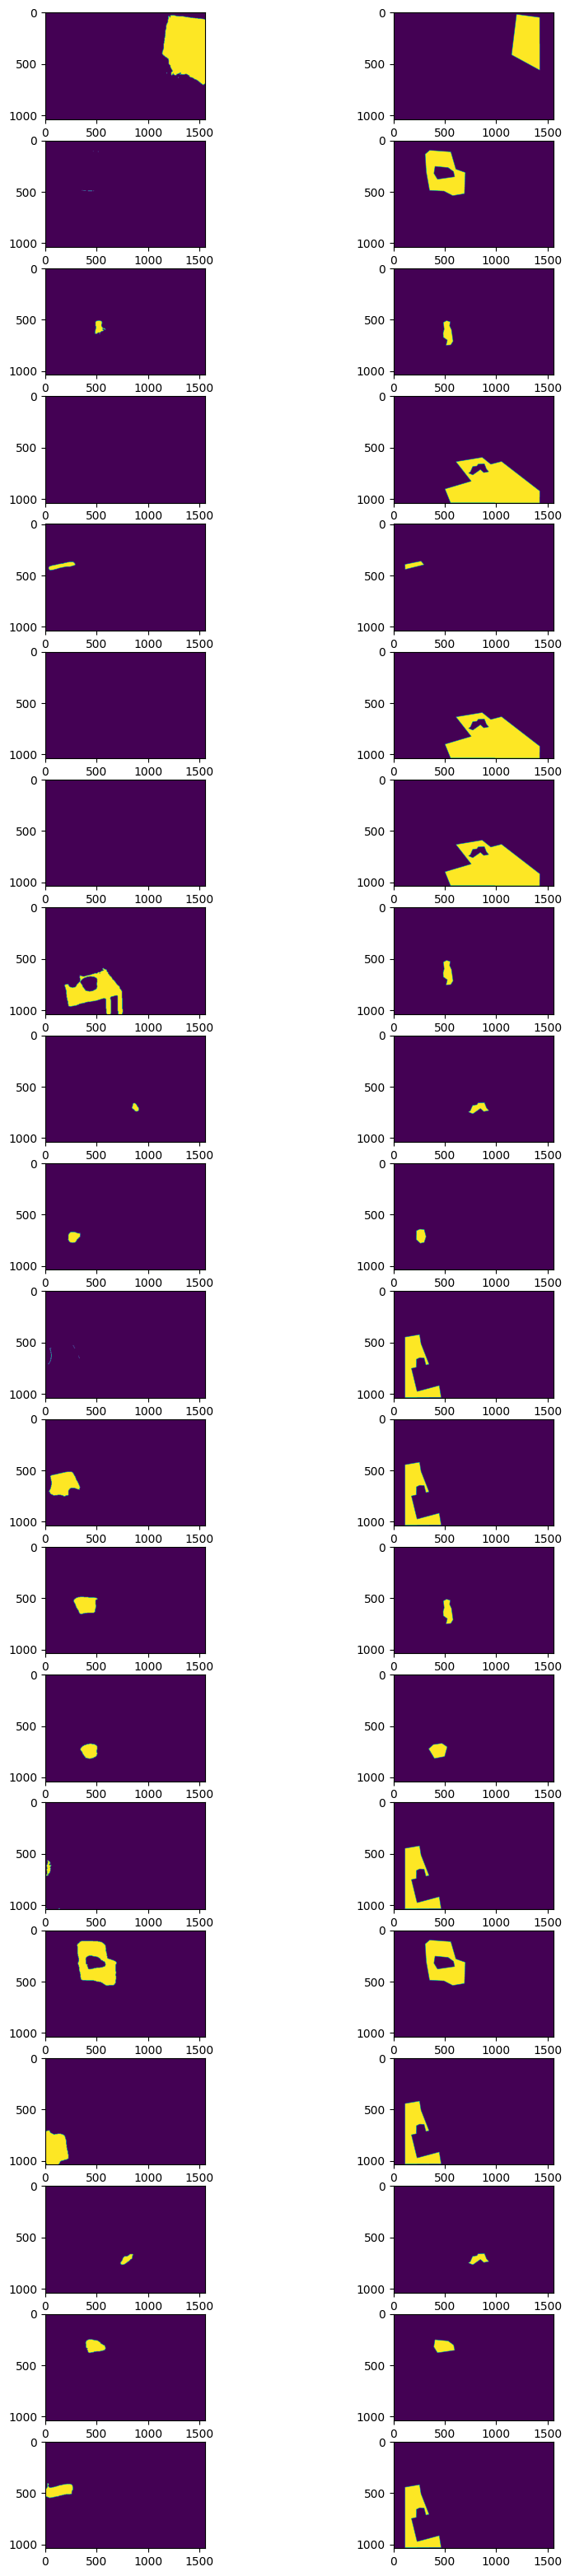

In [24]:
#evaluate the model
ious = evaluation.get_ious_from_masks(masks, gt_masks)

for i in range(len(ious)):
    print(f"the max ious of mask {i} is: {ious[i][1]} with iou = {ious[i][0]}")

best_match_num = len(masks)
fig, ax = plt.subplots(best_match_num, 2, figsize=(10, 40))  # 1 row, 2 columns

for i in range(best_match_num):
    ax[i,0].imshow(masks[i])
    ax[i,1].imshow(gt_masks[ious[i][1]])


The true positif seems satisfying. But some objects are missing